# Import Libraries

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

import cv2
import imghdr

import numpy as np

In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

## GPU Configuration

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Data Preparation

In [4]:
data_path = r'D:\projects\z datasets\dogs-vs-cats\train'

In [5]:
os.listdir(data_path)

['cat', 'dog']

In [6]:
img_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [7]:
img_example = cv2.imread(os.path.join(data_path, 'cat', 'cat.11985.jpg'))
img_example.shape

(375, 499, 3)

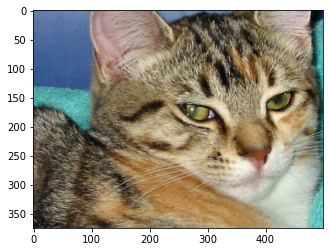

In [8]:
plt.imshow(cv2.cvtColor(img_example, cv2.COLOR_BGR2RGB))

In [9]:
img_example = cv2.imread(os.path.join(data_path, 'cat', 'cat.10000.jpg'))
img_example.shape

(359, 431, 3)

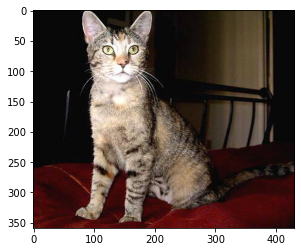

In [10]:
plt.imshow(cv2.cvtColor(img_example, cv2.COLOR_BGR2RGB))

In [11]:
tf.keras.utils.image_dataset_from_directory??

tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)

# Load Data

In [12]:
# use tensorflow dataset pipeline to make dataset instead of loading everything into memory

data = tf.keras.utils.image_dataset_from_directory(data_path) # (data_path, batch_size=8, img_size= (128, 128))


Found 24999 files belonging to 2 classes.


- tensor flow build a dataset of 24999 entries belonging to 2 classes

In [13]:
type(data)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [14]:
data_iterator = data.as_numpy_iterator()

In [15]:
batch = data_iterator.next()

In [16]:
type(batch)

tuple

In [17]:
len(batch) # imgs, labels

2

In [18]:
batch[0].shape # [ 0 ] -> list of 32 imgs of size 256 * 256 * 3 

(32, 256, 256, 3)

In [19]:
batch[0][0].shape

(256, 256, 3)

In [20]:
batch[1]

array([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1])

In [21]:
batch[1].shape

(32,)

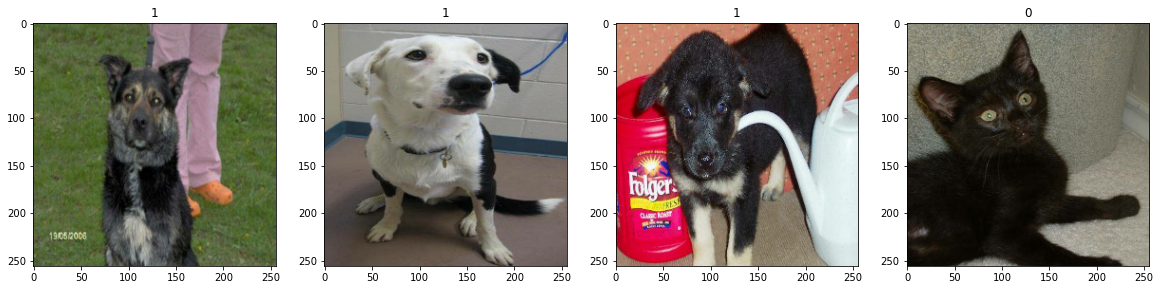

In [22]:
fig, ax= plt.subplots(ncols= 4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [23]:
other_batch = data_iterator.next()

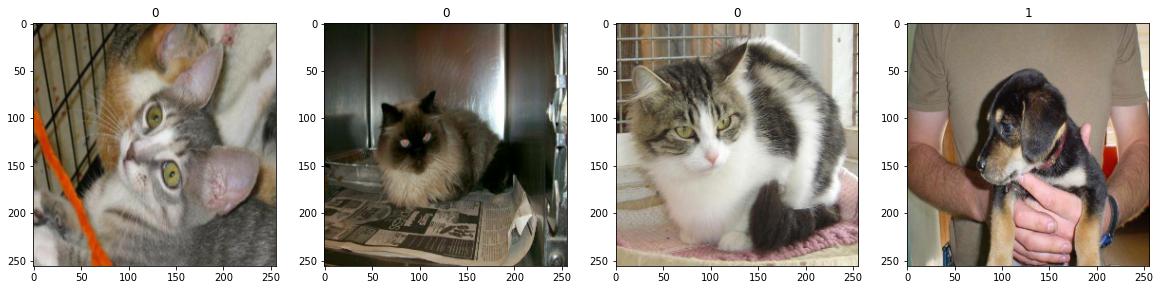

In [24]:
fig, ax= plt.subplots(ncols= 4, figsize=(20, 20))
for idx, img in enumerate(other_batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(other_batch[1][idx])

# Preprocessing Images for DL

- Normalize data

In [25]:
data = data.map(lambda x,y: (x/255, y))

In [26]:
scaled_data_iterator = data.as_numpy_iterator()

In [27]:
scaled_batch = scaled_data_iterator.next()

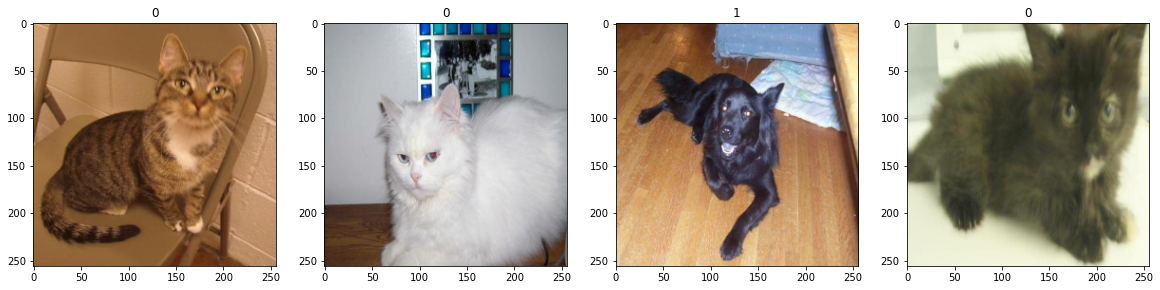

In [28]:
fig, ax= plt.subplots(ncols= 4, figsize=(20, 20))
for idx, img in enumerate(scaled_batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(scaled_batch[1][idx])

split data

- Split data into train, validation, and test sets

In [29]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [30]:
print(train_size, val_size, test_size) # train 547 batchs, val 156 batches, 78 test batchs

547 156 78


In [31]:
# prepare data --> data is shuffled
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [32]:
len(test)

78

# Createing DL Classifier

Model 1

In [34]:
base = Sequential ([
                        
    Conv2D(16, (3, 3), 1, activation= 'relu', input_shape= (256, 256, 3)),
    MaxPooling2D(),
    
    
    Conv2D(32, (3, 3), 1, activation= 'relu'),
    MaxPooling2D(),
    
    Conv2D(16, (3, 3), 1, activation= 'relu'),
    MaxPooling2D(),
    
    Flatten(),
    
    Dense(256, activation= 'relu'),
    Dense(1, activation= 'sigmoid')
                        
])

In [35]:
base.compile('adam', loss= tf.losses.BinaryCrossentropy(), metrics= ['accuracy'])

In [36]:
base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [37]:
logdir = r'D:\projects\z datasets\dogs-vs-cats\logs'

In [38]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= logdir)
checkpoint = ModelCheckpoint('base_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [39]:
history = base.fit(train, epochs= 20, validation_data= val, callbacks= [tensorboard_callback, checkpoint])

Epoch 1/20
547/547 [==============================] - ETA: 0s - loss: 0.6236 - accuracy: 0.6449
Epoch 1: val_accuracy improved from -inf to 0.74840, saving model to base_model.h5
547/547 [==============================] - 126s 218ms/step - loss: 0.6236 - accuracy: 0.6449 - val_loss: 0.5292 - val_accuracy: 0.7484
Epoch 2/20
547/547 [==============================] - ETA: 0s - loss: 0.4922 - accuracy: 0.7607
Epoch 2: val_accuracy improved from 0.74840 to 0.77244, saving model to base_model.h5
547/547 [==============================] - 24s 44ms/step - loss: 0.4922 - accuracy: 0.7607 - val_loss: 0.4716 - val_accuracy: 0.7724
Epoch 3/20
546/547 [============================>.] - ETA: 0s - loss: 0.3974 - accuracy: 0.8156
Epoch 3: val_accuracy improved from 0.77244 to 0.77644, saving model to base_model.h5
547/547 [==============================] - 24s 44ms/step - loss: 0.3976 - accuracy: 0.8155 - val_loss: 0.4598 - val_accuracy: 0.7764
Epoch 4/20
547/547 [==============================] - ET

plot performance

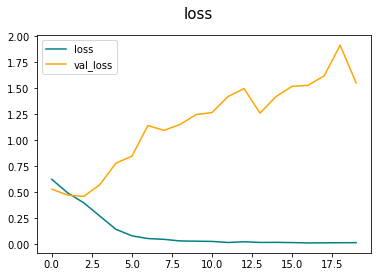

In [40]:
fig = plt.figure()
plt.plot(history.history['loss'], color= 'teal', label= 'loss')
plt.plot(history.history['val_loss'], color= 'orange', label= 'val_loss')
fig.suptitle('loss', fontsize= 15)
plt.legend(loc= 'upper left')
plt.show()

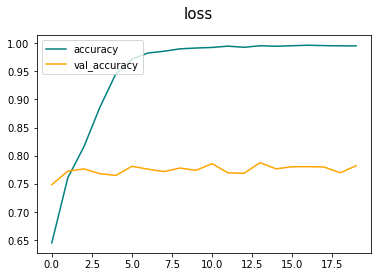

In [41]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color= 'teal', label= 'accuracy')
plt.plot(history.history['val_accuracy'], color= 'orange', label= 'val_accuracy')
fig.suptitle('loss', fontsize= 15)
plt.legend(loc= 'upper left')
plt.show()

Model Is Overfitting

- Another architecture

In [104]:
model3 = Sequential ([
                        
    Conv2D(32, (3, 3), 1, activation= 'relu', kernel_regularizer=l2(0.01), input_shape= (256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),
    
    Conv2D(32, (3, 3), 1, activation= 'relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),
    
    Conv2D(64, (3, 3), 1, activation= 'relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.3),
    
    Flatten(),
    
    Dense(128, activation= 'relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation= 'relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(1, activation= 'sigmoid')
                        
])

In [105]:
model3.compile('adam', loss= tf.losses.BinaryCrossentropy(), metrics= ['accuracy'])

In [106]:
model3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 254, 254, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 127, 127, 32)      0         
                                                                 
 conv2d_28 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 batch_normalization_6 (Batc  (None, 125, 125, 32)    

In [111]:
logdir = r'D:\projects\z datasets\dogs-vs-cats\logs'

In [112]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= logdir)

In [115]:
checkpoint = ModelCheckpoint('best_model2.h5', monitor='val_accuracy', mode= 'max', save_best_only= True, verbose= 1)

In [116]:
history3 = model3.fit(train, epochs= 20, validation_data= val, callbacks= [tensorboard_callback])

Epoch 1/20
547/547 [==============================] - 41s 70ms/step - loss: 0.7260 - accuracy: 0.6213 - val_loss: 0.7454 - val_accuracy: 0.5731
Epoch 2/20
547/547 [==============================] - 37s 67ms/step - loss: 0.5857 - accuracy: 0.7070 - val_loss: 0.5685 - val_accuracy: 0.7226
Epoch 3/20
547/547 [==============================] - 36s 66ms/step - loss: 0.5193 - accuracy: 0.7574 - val_loss: 0.4946 - val_accuracy: 0.7692
Epoch 4/20
547/547 [==============================] - 37s 67ms/step - loss: 0.4592 - accuracy: 0.7905 - val_loss: 0.5110 - val_accuracy: 0.7520
Epoch 5/20
547/547 [==============================] - 37s 67ms/step - loss: 0.4142 - accuracy: 0.8187 - val_loss: 0.4848 - val_accuracy: 0.7754
Epoch 6/20
547/547 [==============================] - 37s 67ms/step - loss: 0.3557 - accuracy: 0.8514 - val_loss: 0.5512 - val_accuracy: 0.7540
Epoch 7/20
547/547 [==============================] - 36s 67ms/step - loss: 0.3123 - accuracy: 0.8711 - val_loss: 0.4931 - val_accuracy:

plot performance

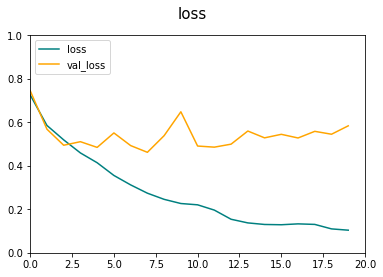

In [127]:
fig = plt.figure()
plt.plot(history3.history['loss'], color= 'teal', label= 'loss')
plt.plot(history3.history['val_loss'], color= 'orange', label= 'val_loss')
fig.suptitle('loss', fontsize= 15)
plt.legend(loc= 'upper left')
plt.xlim(0, 20)
plt.ylim(0, 1)
plt.show()

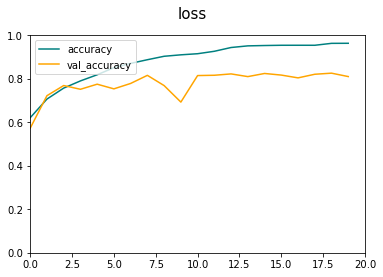

In [126]:
fig = plt.figure()
plt.plot(history3.history['accuracy'], color= 'teal', label= 'accuracy')
plt.plot(history3.history['val_accuracy'], color= 'orange', label= 'val_accuracy')
fig.suptitle('loss', fontsize= 15)
plt.legend(loc= 'upper left')
plt.xlim(0, 20)
plt.ylim(0, 1)
plt.show()

- Model Evaluation

In [143]:
def evaluate_model(model, test_data):
    precision = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()
    accuracy = tf.keras.metrics.BinaryAccuracy()

    for X, y in test_data.as_numpy_iterator():
        yhat = model.predict(X)
        precision.update_state(y, yhat)
        recall.update_state(y, yhat)
        accuracy.update_state(y, yhat)

    print(f"Precision: {precision.result().numpy():.4f}")
    print(f"Recall: {recall.result().numpy():.4f}")
    print(f"Accuracy: {accuracy.result().numpy():.4f}")

In [142]:
evaluate_model(model3, test)

1/1 [==============================] - 0s 18ms/step
Precision: 0.8338
Recall: 0.7598
Accuracy: 0.8125


In [144]:
!pip freeze > requirements.txt
